The code and discussion in this notebook is inspired and borrowed from: 
* [Efficient Bits](2022-01-10-cheminfo_basics_smarts.ipynb)

**The Reaction SMARTS or SMIRKS way to query chemical reactions**

SMIRKS as per the Daylight definition are used to describe a transform (or reaction) to modify molecules. They are rules to make new molecules but also be used a 'Reaction SMARTS' to search for reactions smiles which match that transformation. 

[RDKit](http://www.rdkit.org/docs/RDKit_Book.html#chemical-reaction-handling) treats these slightly differently - it has Reaction SMARTS which are used for substructure matching alone. 

```bash
reaction  ::=   reactants ">>" products
reactants ::=  molecules
products  ::=   molecules
molecules ::=  molecule
               molecules "." molecule
molecule  ::=   a valid SMARTS string without "." characters
                "(" a valid SMARTS string without "." characters ")"
```


<center>
<table border="1">
  <tbody><tr>
    <td colspan="4" align="center">
    <b>Example Reaction SMARTS:</b>
    </td></tr><tr>
      <td align="center">Query:</td>
      <td align="center">Target:</td>
      <td align="center">Matches:</td>
      <td align="center">Comment:</td>
    </tr>
    <tr>
      <td align="center">C&gt;&gt;C</td>
      <td align="center">CC&gt;&gt;CC</td>
      <td align="center">4</td>
      <td>No maps, normal match.</td>
    </tr>	  
    <tr>
      <td align="center">C&gt;&gt;C</td>
      <td align="center">[CH3:7][CH3:8]&gt;&gt; [CH3:7][CH3:8]</td>
      <td align="center">4</td>
      <td>No maps in query, maps in target are ignored.</td>
    </tr>
    <tr>
      <td align="center">[C:1]&gt;&gt;C</td>
      <td align="center">[CH3:7][CH3:8]&gt;&gt; [CH3:7][CH3:8]</td>
      <td align="center">4</td>
      <td>Unpaired map in query ignored.</td>
    </tr>
    <tr>
      <td align="center">[C:1]&gt;&gt;[C:1]</td>
      <td align="center">CC&gt;&gt;CC</td>
      <td align="center">0</td>
      <td>No maps in target, hence no matches.</td>
    </tr>
    <tr>
      <td align="center">[C:?1]&gt;&gt;[C:?1]</td>
      <td align="center">CC&gt;&gt;CC</td>
      <td align="center">4</td>
      <td>Query says mapped as shown or not present.</td>
    </tr>
    <tr>
      <td align="center">[C:1]&gt;&gt;[C:1]</td>
      <td align="center">[CH3:7][CH3:8]&gt;&gt;[CH3:7][CH3:8]</td>
      <td align="center">2</td>
      <td>Matches for target 7,7 and 8,8 atom pairs.</td>
    </tr>
    <tr>
      <td align="center">[C:1]&gt;&gt;[C:2]</td>
      <td align="center">[CH3:7][CH3:8]&gt;&gt; [CH3:7][CH3:8]</td>
      <td align="center">4</td>
      <td>When a query class is not found on both<br>sides of the query, it is
	  ignored;<br>this query does NOT say that the atoms<br>are in different
	  classes. </td>
    </tr>
    <tr>
      <td align="center">[C:1][C:1]&gt;&gt;[C:1]</td>
      <td align="center">[CH3:7][CH3:7]&gt;&gt; [CH3:7][CH3:7]</td>
      <td align="center">4</td>
      <td>Atom maps match with "or" logic.  All atoms<br>get bound to
	  class 7.</td>
    </tr>
    <tr>
      <td align="center">[C:1][C:1]&gt;&gt;[C:1]</td>
      <td align="center">[CH3:7][CH3:8]&gt;&gt; [CH3:7][CH3:8]</td>
      <td align="center">4</td>
      <td>The reactant atoms are bound to classes 7<br>and 8. Note that having
	  the first query atom<br>bound to class 7 does not preclude<br>binding the
	  second atom. Next, the product<br>atom can bind to classes 7 or 8.</td>
    </tr>
    <tr>
      <td align="center">[C:1][C:1]&gt;&gt;[C:1]</td>
      <td align="center">[CH3:7][CH3:7]&gt;&gt; [CH3:7][CH3:8]</td>
      <td align="center">2</td>
      <td>The reactants are bound to class 7.  The<br>product atom can bind to
	  class 7 only.</td>
    </tr>
  
 
</tbody></table>
</center>

In [1]:
# collapse_output
# Install requirements for the tutorial
!pip install pandas rdkit-pypi mols2grid matplotlib scikit-learn ipywidgets

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/lrlhps/apps/python/python-3.8.5/bin/python -m pip install --upgrade pip' command.


In [2]:
import os 
import pandas as pd
import numpy as np 

# RDkit imports
import rdkit
from rdkit import Chem #This gives us most of RDkits's functionality
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
IPythonConsole.ipython_useSVG=True  #SVG's tend to look nicer than the png counterparts
print(rdkit.__version__)

## Enumerator 
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import rdMolEnumerator

# Mute all errors except critical
Chem.WrapLogs()
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

from collections import defaultdict
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

2021.09.3


In [3]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# High DPI rendering for mac
%config InlineBackend.figure_format = 'retina'

# Plot matplotlib plots with white background: 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plot_params = {
'font.size' : 15,
'axes.titlesize' : 15,
'axes.labelsize' : 15,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 12,
'ytick.labelsize' : 12,
}
 
plt.rcParams.update(plot_params)

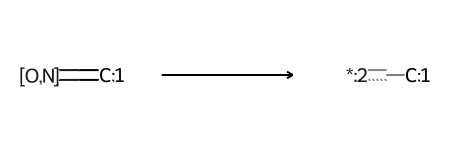

In [4]:
rxn = AllChem.ReactionFromSmarts('[C:1]=[O,N:2]>>[C:1][*:2]')
rxn

In [5]:
[Chem.MolToSmiles(x,1) for x in rxn.RunReactants((Chem.MolFromSmiles('CC=O'),))[0]]

['CCO']

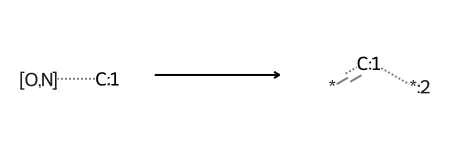

In [6]:
rxn = AllChem.ReactionFromSmarts('[C:1]~[O,N:2]>>*[C:1]~[*:2]')
rxn

In [7]:
[Chem.MolToSmiles(x,1) for x in rxn.RunReactants((Chem.MolFromSmiles('C#N'),))[0]]

['*C#N']

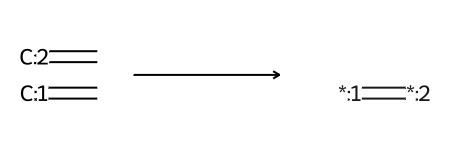

In [8]:
rxn = AllChem.ReactionFromSmarts("([C:1]=[C;H2].[C:2]=[C;H2])>>[*:1]=[*:2]")
rxn

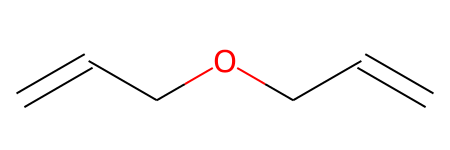

In [9]:
m1 = Chem.MolFromSmiles('C=CCOCC=C')
m1

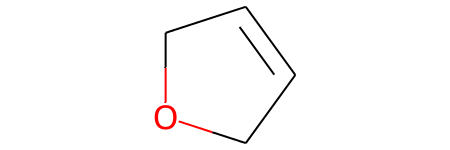

In [10]:
ps = rxn.RunReactants((m1,))
ps[0][0]

### Generate positional varying molecules in RDkit 

* [Greg's Intro to molecule enumerator](https://greglandrum.github.io/rdkit-blog/tutorial/substructure/2021/05/13/intro-to-the-molecule-enumerator.html)
* [Greg's single molecule reaction blog](https://greglandrum.github.io/rdkit-blog/tutorial/reactions/2021/12/15/single-molecule-reactions.html)
* [Molecule enumerator blog](https://github.com/RobinEkberg/Molecular-enumeration/blob/main/Mol-enum_new.ipynb)

In [11]:
#Sanitise generated regio isomers
from rdkit.Chem import rdFMCS
def align_bundle_coords(bndl):
    ps = rdFMCS.MCSParameters()
    for m in bndl:
        Chem.SanitizeMol(m)
    mcs = rdFMCS.FindMCS(bndl,completeRingsOnly=True)
    q = Chem.MolFromSmarts(mcs.smartsString)
    rdDepictor.Compute2DCoords(q)
    for m in bndl:
        rdDepictor.GenerateDepictionMatching2DStructure(m,q)

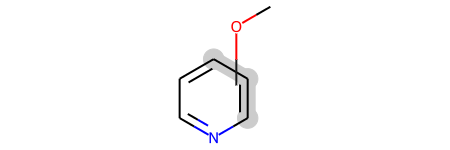

In [12]:
pv1 = Chem.MolFromMolBlock('''
  Mrv2007 06232015292D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 9 8 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -1.7083 2.415 0 0
M  V30 2 C -3.042 1.645 0 0
M  V30 3 C -3.042 0.105 0 0
M  V30 4 N -1.7083 -0.665 0 0
M  V30 5 C -0.3747 0.105 0 0
M  V30 6 C -0.3747 1.645 0 0
M  V30 7 * -0.8192 1.3883 0 0
M  V30 8 O -0.8192 3.6983 0 0
M  V30 9 C 0.5145 4.4683 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 8 ENDPTS=(3 1 5 6) ATTACH=ANY
M  V30 8 1 8 9
M  V30 END BOND
M  V30 END CTAB
M  END''')
pv1

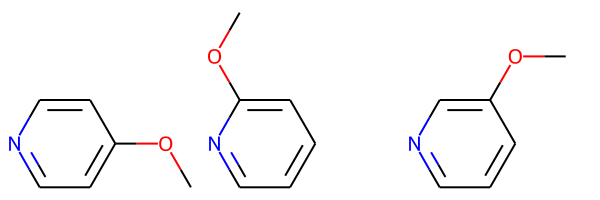

In [13]:
pv1_bundle = rdMolEnumerator.Enumerate(pv1)
align_bundle_coords(pv1_bundle)
Draw.MolsToGridImage(pv1_bundle)

## Set up the reactants and reaction definitions 

In [14]:
from rdkit.Chem import rdmolfiles as rdfiles

lib_alcohols = rdfiles.SmilesMolSupplier('./molecule_enumerations/alcohol.smi') #Read input file with all reactants
lib_alkynes = rdfiles.SmilesMolSupplier('./molecule_enumerations/alkynes.smi')
reaction_library = pd.read_csv('./molecule_enumerations/rxn_definitions.txt', sep='\t', index_col = 'ReactionName')
reaction_library

,ReactionSMARTS
ReactionName,
Primary alc ox,[CH2:1][OD1] >> [C:1]=[OD1]
Amide coupling,[C:1](=[O:2])O.[N:3] >> [C:1](=[O:2])[N:3]
Diels-Alder,'[C:1]=[C:2]-[C:3]=[C:4].[C:5]=[C:6] >> [C:5]-...
4-Click,[N:1]=[N+1:2]=[N-1:3].[CH:4]#[C:5]>>[N:1]-1-[C...


## Single molecule reaction

In [15]:
def unimolecular(molecule, reaction_smirk):
  rxn = AllChem.ReactionFromSmarts(reaction_smirk)
  product = rxn.RunReactants([molecule,])
  
  final_smiles_list = []
  try: 
    for i in range(len(product)):
      final_smiles = Chem.MolToSmiles(product[i][0])
      final_smiles_list.append(final_smiles)
  except:
    pass
  return final_smiles_list

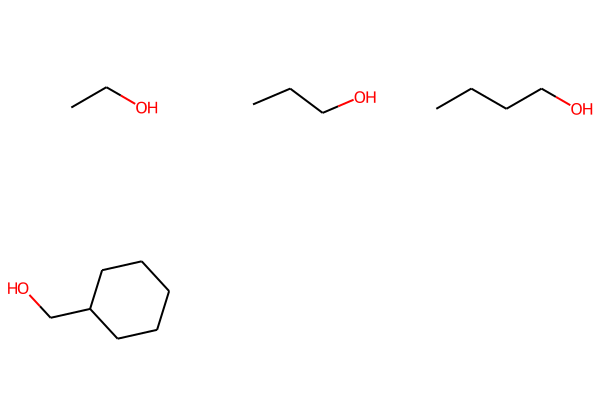

In [16]:
Draw.MolsToGridImage(lib_alcohols)

In [17]:
reaction_library.ReactionSMARTS['Primary alc ox']

'[CH2:1][OD1] >> [C:1]=[OD1]'

In [18]:
unimolecular(lib_alcohols[0], reaction_library.ReactionSMARTS['Primary alc ox'])

['CC=O']

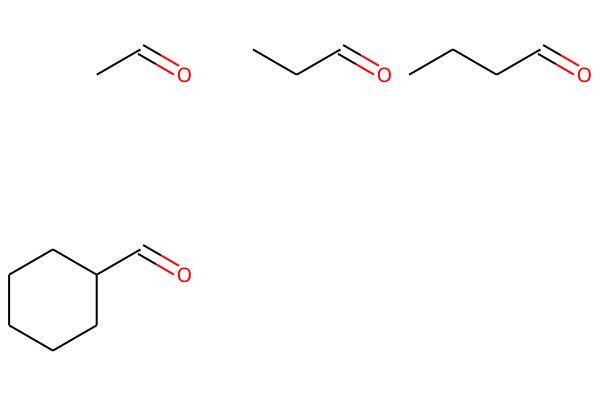

In [25]:
products = []
for alcohol_mol in lib_alcohols:
  prod = unimolecular(alcohol_mol, reaction_library.ReactionSMARTS['Primary alc ox'])
  for mol in prod:
    product = Chem.MolFromSmiles(mol)
    products.append(product)
align_bundle_coords(products)
Draw.MolsToGridImage(products)

## Reacting two compounds

In [20]:
def bimolecular_rxn(mol1, mol2, reaction_smirk):
  rxn = AllChem.ReactionFromSmarts(reaction_smirk)
  product = rxn.RunReactants([mol1, mol2])
  
  final_smiles_list = []
  try: 
    for i in range(len(product)):
      final_smiles = Chem.MolToSmiles(product[i][0])
      final_smiles_list.append(final_smiles)
  except:
    pass
  return final_smiles_list

In [21]:
reaction_smirks = reaction_library.ReactionSMARTS["4-Click"] #Define the reaction type from the reaction library
reaction_smirks

'[N:1]=[N+1:2]=[N-1:3].[CH:4]#[C:5]>>[N:1]-1-[CH:4]=[C:5]-[N-0:3]=[N+0:2]-1'

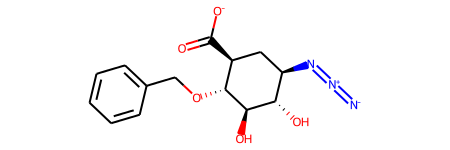

In [22]:
product_bimolecular = [] #List of enumerated molecules
Core = Chem.MolFromSmiles('O[C@@H]1[C@@H](O)[C@H](OCC2=CC=CC=C2)[C@H](C[C@H]1N=[N+]=[N-])C([O-])=O') #Define the molecular core
Core

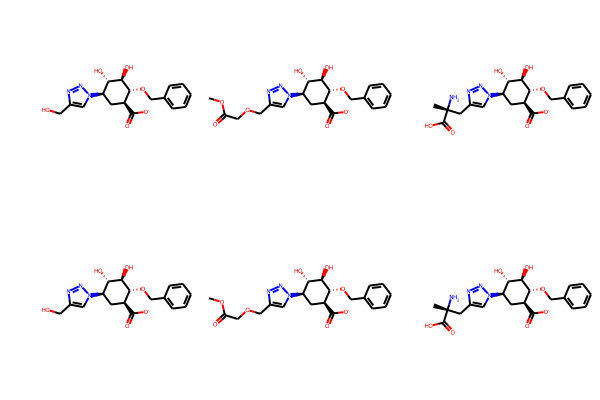

In [24]:
for i in lib_alkynes: #Read the .smi-file of reagents to be used for enumeration
    resulting_smiles = bimolecular_rxn(Core, i, reaction_smirks)
    
    for i in resulting_smiles:
        prod1 = Chem.MolFromSmiles(i)
        product_bimolecular.append(prod1)
align_bundle_coords(product_bimolecular)
Draw.MolsToGridImage(product_bimolecular)